In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import torch.nn as nn

In [3]:
#load data and adapt to run on cuda:  https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
#check data
iterator = iter(trainloader)
X,y = iterator.next()
X,y = X.cuda(), y.cuda()
X.shape

torch.Size([32, 3, 32, 32])

Create ResNet as modular architecture using Pytorch

In [5]:
class IdentityBlock(nn.Module):
  def __init__(self, input_channels, output_channels, downsample):
    super().__init__()
    #shortest block unit of two convolutions including one identity convolution necessary to adapt the number of filters and size of the input
    out_size = output_channels
    self.conv1 = nn.Conv2d(in_channels = input_channels, out_channels = out_size, kernel_size = 3, stride = 1, padding = 1)
    self.relu1 = nn.ReLU(inplace=True)
    self.bn1 = nn.BatchNorm2d(out_size)

    if downsample:
      stride_ = 2
    else:
      stride_ = 1

    self.conv2 = nn.Conv2d(in_channels = out_size, out_channels = out_size, kernel_size = 3, stride = stride_, padding = 1)
    self.relu2 = nn.ReLU(inplace=True)
    self.bn2 = nn.BatchNorm2d(out_size)

    #convolution to create right amount of layers for identity
    self.conv_id = nn.Conv2d(in_channels = input_channels, out_channels = out_size, kernel_size = 3, stride = stride_, padding = 1)
    self.bn_id = nn.BatchNorm2d(out_size)

    self.downsample = downsample


  def forward(self,x):
    #identity = x
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.bn1(out)

    out = self.conv2(out)
    out = self.relu2(out)
    out = self.bn2(out)

    #create right shape of identity
    identity = self.conv_id(x)
    identity = self.bn_id(identity)

    #passing forward residual
    out += identity

    return out


In [6]:
class ResNet(nn.Module):
  #create Resnet model by creating 3 blocks of combinations of the identity module
  def __init__(self, block, layers_n = 3, num_classes=10):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                            bias=False)
    self.bn1 = nn.BatchNorm2d(16)
    self.relu = nn.ReLU(inplace=True)

    self.layers0 = self.create_layers(block, 16, 16, layers_n)
    self.layers1 = self.create_layers(block, 16, 32, layers_n)
    self.layers2 = self.create_layers(block, 32, 64, layers_n)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    
    self.fc = nn.Linear(64 , num_classes)
    self.sm = nn.Softmax(dim = 1)

  def create_layers(self, block, input_size, output_size, layers_n):
    #function to create layers for one block of n>1 repetitions
    layers = []
    layers.append(block(input_channels = input_size, output_channels = output_size, downsample = False))
    layers.append(block(input_channels = output_size, output_channels = output_size, downsample = False))
    for n in range(layers_n-2):
      layers.append(block(input_channels = output_size, output_channels = output_size, downsample = False))
      layers.append(block(input_channels = output_size, output_channels = output_size, downsample = False))
    layers.append(block(input_channels = output_size, output_channels = output_size, downsample = False))
    layers.append(block(input_channels = output_size, output_channels = output_size, downsample = True))

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    
    x = self.layers0(x)
    x = self.layers1(x)
    x = self.layers2(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    
    x = self.fc(x)
    x = self.sm(x)

    return x

    

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()


In [9]:
#calculate accuracy between two pytorch tensors
def accuracy(res, y):
  return (torch.argmax(res, dim = 1) == y).float().mean()

In [10]:
#function to return test accuracy and test loss from testloader
def test_model(model, testloader, lossfunc):
  loss_sum = 0.0
  losscounter = 0
  acc_sum = 0.0
  for i, data in enumerate(testloader, 0):
    losscounter +=1
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda() 
    outputs = model(inputs)
    loss = lossfunc(outputs, labels).item()
    acc = accuracy(outputs, labels).item()
    loss_sum+=loss
    acc_sum+=acc
  return (loss_sum/losscounter),(acc_sum/losscounter)



In [12]:
import matplotlib.pyplot as plt

Training models of lengths n = 2-5 for 20 epochs, adam optimizer, lr 1e-4, loss = CategoricalCrossentropy

2[1, 200 loss: 0.22203818655014038]
2[1, 400 loss: 0.21284669971466064]
2[1, 600 loss: 0.2081180209517479]
2[1, 800 loss: 0.20454483902454376]
2[1, 1000 loss: 0.20158562761545182]
2[1, 1200 loss: 0.19994759517908095]
2[1, 1400 loss: 0.19944503158330917]
network: 2, epoch: 1, trainingloss: 2.0584578360034653, testloss: 1.9786591118517014, acc: 0.4849241214057508
2[2, 200 loss: 0.19578210693597795]
2[2, 400 loss: 0.1947776358127594]
2[2, 600 loss: 0.19417851603031158]
2[2, 800 loss: 0.19211043018102647]
2[2, 1000 loss: 0.1926089733839035]
2[2, 1200 loss: 0.19126098042726516]
2[2, 1400 loss: 0.1917466078400612]
network: 2, epoch: 2, trainingloss: 1.9284393398409383, testloss: 1.912855371880455, acc: 0.5487220447284346
2[3, 200 loss: 0.18884346997737886]
2[3, 400 loss: 0.18909175139665604]
2[3, 600 loss: 0.18756267607212065]
2[3, 800 loss: 0.18806328594684601]
2[3, 1000 loss: 0.1870780678987503]
2[3, 1200 loss: 0.18695055204629898]
2[3, 1400 loss: 0.1858600127696991]
network: 2, epoch: 3, 

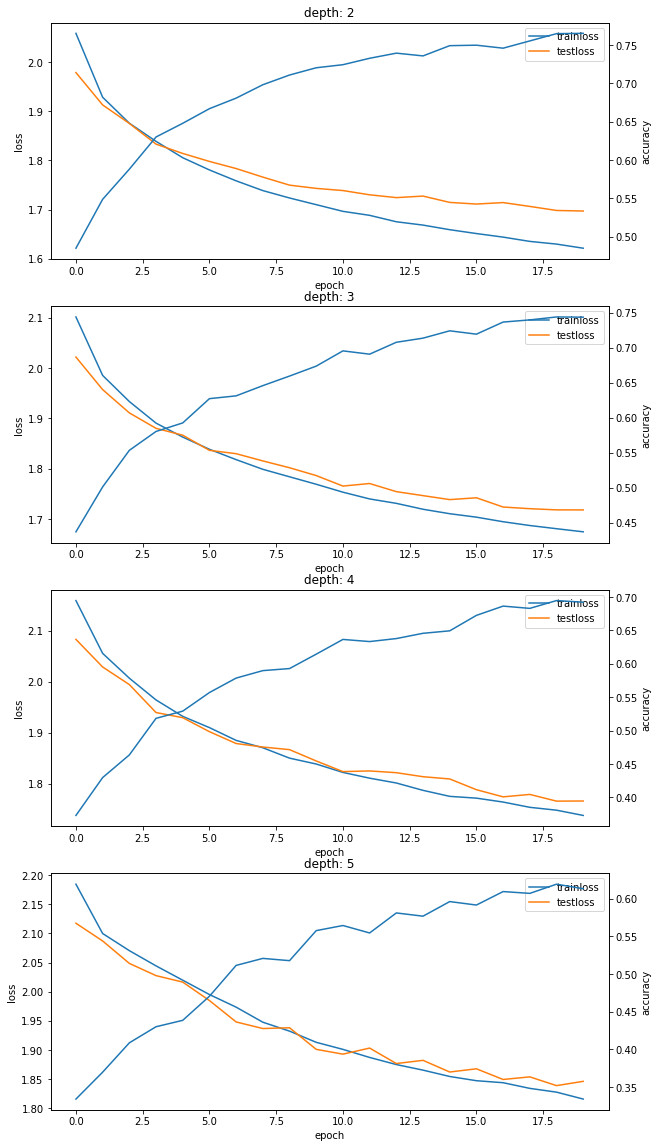

In [30]:
epochs = 20

f, axs = plt.subplots(4, 1, figsize=(10,20))

all_models = []
trainloss = []
testloss = []
testacc = []
for l in [2,3,4,5]:
  network = ResNet(IdentityBlock, layers_n = l, num_classes = 10)
  #network = Net()
  if torch.cuda.is_available():
    network.cuda()
  optimizer = optim.Adam(network.parameters(), lr = 1e-4)
  networktrloss = []
  networkteloss = []
  networkacc = []
  for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    epoch_loss = 0.0
    subepoch_counter = 0
    for i, data in enumerate(trainloader, 0):
        subepoch_counter +=1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda() 

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('{}[{}, {} loss: {}]'.format(l, epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        epoch_loss += loss.item()
    eloss = epoch_loss/subepoch_counter
    tloss, acc = test_model(network, testloader, criterion)
    networktrloss.append(eloss)
    #test model: 
    networkteloss.append(tloss)
    networkacc.append(acc)
    print("network: {}, epoch: {}, trainingloss: {}, testloss: {}, acc: {}".format(l, epoch+1, eloss, tloss, acc))
  #save models and visualize losses, accuracy
  all_models.append(network)
  torch.save(model.state_dict(), "model_{}".format(l))
  testloss.append(networkteloss)
  trainloss.append(networktrloss)
  testacc.append(networkacc)


  axs[l-2].plot(networktrloss, label = "trainloss")
  axs[l-2].plot(networkteloss, label = "testloss")
  ax2=axs[l-2].twinx()
  ax2.plot(networkacc, label = "accuracy")
  axs[l-2].set_ylabel("loss")
  ax2.set_ylabel("accuracy")
  axs[l-2].set_xlabel("epoch")
  axs[l-2].set_title('depth: {}'.format(l))
  axs[l-2].legend()
print('Finished Training')



For limited computational power and training time, n=2 seems to be the best example we have tried. We can see that at n=5 the optimization process seems to not always improve the results with each epoch, therefore suggesting that going even deeper than that might not be a good idea.

In [26]:
#save models 
for i in range(len(all_models)):
  model = all_models[i]
  torch.save(model.state_dict(), "model_{}".format(i))

In [93]:
#create model and reload fitting model weights 
model = ResNet(IdentityBlock, layers_n = 2, num_classes = 10).cuda()
model.load_state_dict(torch.load("model_2"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layers0): Sequential(
    (0): IdentityBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU(inplace=True)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2): ReLU(inplace=True)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_id): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_id): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): IdentityBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU(inplace=True

In [36]:
import numpy as np

In [16]:
#test if accuracy is preserved -> yes
test_model(model.cuda(), testloader, criterion)

(1.6881946504306489, 0.7732627795527156)

In [32]:
def plotNum(num):
    fig, ax = plt.subplots(1,3)
    min_val, max_val = -1, 1
    for i in range(3):
      ax[i].matshow(num[i,:,:], cmap=plt.cm.Blues)
    plt.show()

def plotweights(weights ):
    for i in range(weights.shape[0]):
       plotNum(weights[i])

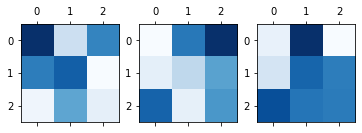

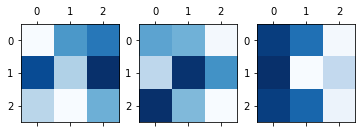

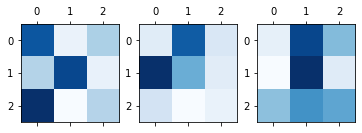

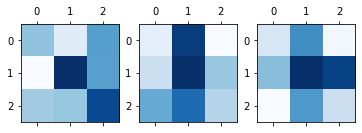

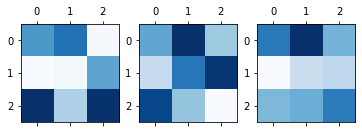

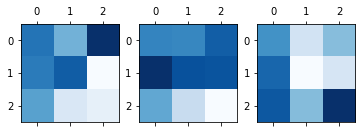

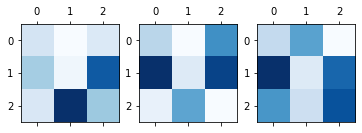

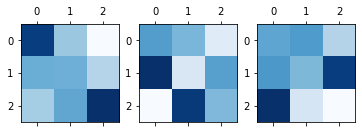

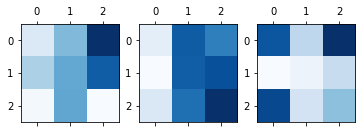

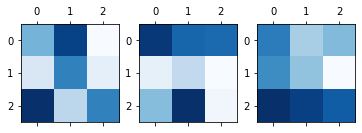

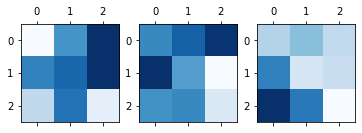

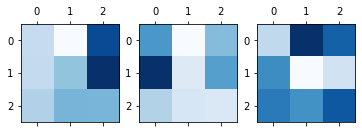

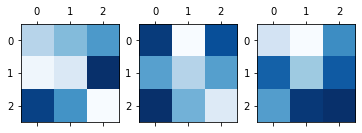

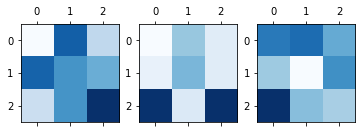

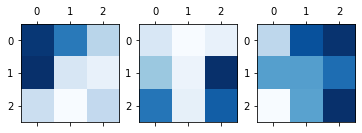

In [40]:
plotweights(model.conv1.weight.cpu().detach().numpy())

The filters from the first layer (16 filters for each of the 3 color channels) do extract abstract geometrical forms. However, just based on these filters it is hard to tell which way information is passed on in the following convolutions. But it is clearly visible that the first convolution is looking for certain abstract geometrical structures such as lines

In [45]:
#input for identity layers would be content before identity blocks
#identity layers: layers0/1/2, identity_blocks 0/1/2/3, conv__id



torch.Size([16, 16, 3, 3])

In [74]:
# get activations after specific layer: https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/18
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [94]:
#register forward hooks on input and output layers of supposed identity layers
activation = {}
model.relu.register_forward_hook(get_activation('conv_in_0'))
counter = 0

for j in [0,1,2,3]:
  model.layers0[j].conv_id.register_forward_hook(get_activation('conv_out_{}'.format(counter)))
  model.layers0[j].bn_id.register_forward_hook(get_activation('conv_in_{}'.format(counter +1)))
  counter +=1
for j in [0,1,2,3]:
  model.layers1[j].conv_id.register_forward_hook(get_activation('conv_out_{}'.format(counter)))
  model.layers1[j].bn_id.register_forward_hook(get_activation('conv_in_{}'.format(counter +1)))
  counter +=1
for j in [0,1,2,3]:
  model.layers2[j].conv_id.register_forward_hook(get_activation('conv_out_{}'.format(counter)))
  model.layers2[j].bn_id.register_forward_hook(get_activation('conv_in_{}'.format(counter +1)))
  counter +=1


output = model(X)


In [95]:
activation.keys()

dict_keys(['conv_in_0', 'conv_out_0', 'conv_in_1', 'conv_out_1', 'conv_in_2', 'conv_out_2', 'conv_in_3', 'conv_out_3', 'conv_in_4', 'conv_out_4', 'conv_in_5', 'conv_out_5', 'conv_in_6', 'conv_out_6', 'conv_in_7', 'conv_out_7', 'conv_in_8', 'conv_out_8', 'conv_in_9', 'conv_out_9', 'conv_in_10', 'conv_out_10', 'conv_in_11', 'conv_out_11', 'conv_in_12'])

In [99]:
loss = nn.MSELoss()
#calculate MSE for those tensors that have the same shape
for i in range(12):
  a1 = activation["conv_in_{}".format(i)]
  a2 = activation["conv_out_{}".format(i)]
  if a1.shape == a2.shape:
    l = loss(a1, a2)
    print(l.item())

0.6734559535980225
2.194471836090088
2.4425854682922363
2.384509563446045
2.9781479835510254
4.561967849731445
4.655255317687988


20 Training epochs do not seem to be sufficient for the identity layer to learn to be the identity and the MSE increases with an increasing number of layers.





Deeper is not always better. Our Training examples above show that for short training durations such as 20 epochs, a shorter network can be trained more easily. The shortest network in our example had two identity blocks for each of the three major blocks and showed the highest accuracy after 20 epochs (~75%). This might change whith further training since at some point the deeper networks will be able to differenciate more precisely between individual features. 

However, depending on the size of the dataset, there might not be enough data to train a bigger network, therefore not increasing the overall performance.

The network size has to be adapted to the size of the training dataset, the amount of information in each data sample and the amount of computational power that should be invested in training and predicting samples.


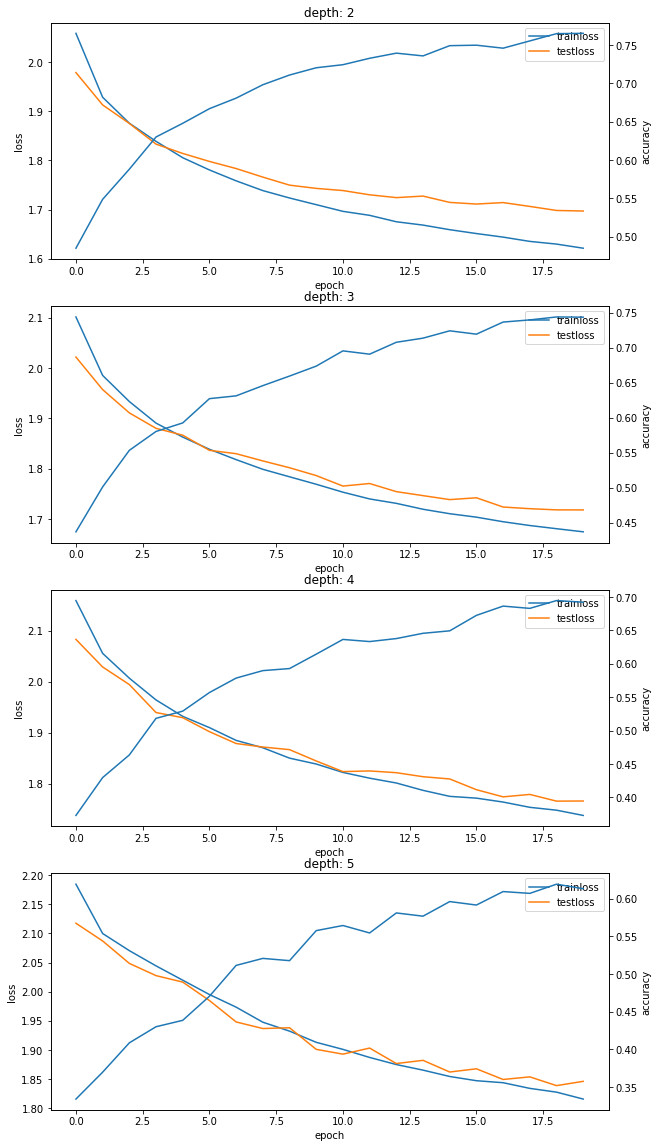